# *Bidirectional LSTM* is a sequence model which contains two LSTM layers, one for processing input in the forward direction and the other for processing in the backward direction

# **Data Preprocessing for datasets**

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import wordcloud

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

import warnings
warnings.filterwarnings('ignore')

<ipython-input-2-b00d50b9414f>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [4]:
wiki_data = pd.read_csv("train.csv")

In [5]:
wiki_data.drop(columns = {'id','severe_toxic','obscene','threat','insult','identity_hate'},inplace=True)
wiki_data.rename(columns = {'comment_text': 'text', 'toxic':'label'}, inplace = True)

In [6]:
# remove puctunations, https
import re
def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))
    return df


In [7]:
wiki_data = clean_text(wiki_data, 'text')

In [45]:
wiki_data.label.value_counts()

0    144277
1    15294 
Name: label, dtype: int64

In [8]:
stopwords = nltk.corpus.stopwords.words('english')
wiki_data['text'] = wiki_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [37]:
!pip install wordcloud

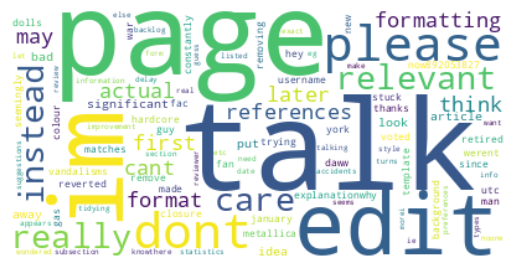

In [47]:
from wordcloud import WordCloud
# instantiate a word cloud object
wiki_wc = WordCloud(
    background_color='white',
    stopwords=stopwords
)
# generate the word cloud
wiki_wc.generate(str(wiki_data['text']))

# display the word cloud
plt.imshow(wiki_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# Basic NLP

In [9]:
from collections import Counter

#count unique words
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word]+=1
    return count

In [10]:
counter = counter_word(wiki_data['text'])

In [11]:
counter

Counter({'explanationwhy': 1,
         'edits': 9731,
         'made': 9518,
         'username': 1758,
         'hardcore': 147,
         'metallica': 35,
         'fan': 797,
         'reverted': 3850,
         'werent': 452,
         'vandalisms': 38,
         'closure': 85,
         'gas': 317,
         'voted': 297,
         'new': 10393,
         'york': 881,
         'dolls': 20,
         'fac': 285,
         'please': 27794,
         'dont': 25874,
         'remove': 5095,
         'template': 2830,
         'talk': 30927,
         'page': 43873,
         'since': 8422,
         'im': 18624,
         'retired': 222,
         'now892053827': 2,
         'daww': 1,
         'matches': 341,
         'background': 694,
         'colour': 205,
         'seemingly': 164,
         'stuck': 336,
         'thanks': 11950,
         '2151': 8,
         'january': 1134,
         '11': 910,
         '2016': 69,
         'utc': 3711,
         'hey': 2496,
         'man': 2630,
         'real

In [12]:
len(counter)

294575

In [13]:
# the size of dictionary
num_words = len(counter)

#max number of words in a sequence
max_length = 20

# **Train/test split**

In [14]:
#train_size3 = int(data3.shape[0] * 0.8)
#train3 = int(data3.shape[0] * 0.1)
train_size = int(wiki_data.shape[0] * 0.1 * 0.8)

train_sentences = wiki_data.text[:train_size]
train_labels = wiki_data['label'][:train_size]
test_sentences = wiki_data.text[train_size:]
test_labels = wiki_data['label'][train_size:]

In [15]:
print(train_size)


12765


In [16]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

train_padded = pad_sequences(
    train_sequences,maxlen = max_length, padding = "post", truncating = "post")
test_padded = pad_sequences(
    test_sequences,maxlen = max_length, padding = "post", truncating = "post")

In [17]:
print("Actual sentence....")
print(wiki_data.text[1])
print("Tokenised vector.....")
print(train_sequences[1])

Actual sentence....
daww matches background colour im seemingly stuck thanks talk 2151 january 11 2016 utc
Tokenised vector.....
[20345, 2104, 1537, 5269, 12, 3230, 2449, 30, 4, 20346, 955, 1007, 5713, 199]


#Check inverse

In [18]:
reverse_word_index = dict([value,key] for (key,value) in word_index.items())

In [19]:
def decode(text):
    return " ".join([reverse_word_index.get(i,"?") for i in text])

In [20]:
decode(train_sequences[0])

'explanationwhy edits made username hardcore metallica fan reverted werent vandalisms closure gas voted new york dolls fac please dont remove template talk page since im retired now892053827'

In [21]:
train_padded.shape

(12765, 20)

In [22]:
test_padded.shape

(146806, 20)

## Build model

In [23]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.initializers import Constant
from keras.optimizers.legacy import Adam

model = Sequential()

model.add(Embedding(num_words, 32, input_length = max_length, name = 'embed_layer'))
model.add(Bidirectional(LSTM(64), name = 'bilstm_layer'))
model.add(Dense(1,activation = "sigmoid", name = 'dense_layer'))

optimizer = Adam(learning_rate = 3e-4)

model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embed_layer (Embedding)     (None, 20, 32)            9426400   
                                                                 
 bilstm_layer (Bidirectiona  (None, 128)               49664     
 l)                                                              
                                                                 
 dense_layer (Dense)         (None, 1)                 129       
                                                                 
Total params: 9476193 (36.15 MB)
Trainable params: 9476193 (36.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# **Training on dataset**

In [25]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
batch_size = 32

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

history = model.fit(train_padded, train_labels, batch_size=batch_size, epochs=20, verbose=1, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_split=0.25,)

Epoch 1/20
300/300 [==============================] - 64s 199ms/step - loss: 0.3262 - accuracy: 0.9012 - val_loss: 0.1853 - val_accuracy: 0.9330 - lr: 3.0000e-04
Epoch 2/20
300/300 [==============================] - 60s 198ms/step - loss: 0.1368 - accuracy: 0.9540 - val_loss: 0.1661 - val_accuracy: 0.9474 - lr: 3.0000e-04
Epoch 3/20
300/300 [==============================] - 58s 192ms/step - loss: 0.0540 - accuracy: 0.9821 - val_loss: 0.2043 - val_accuracy: 0.9408 - lr: 3.0000e-04
Epoch 4/20
300/300 [==============================] - 58s 194ms/step - loss: 0.0202 - accuracy: 0.9940 - val_loss: 0.2604 - val_accuracy: 0.9101 - lr: 3.0000e-04
Epoch 5/20
300/300 [==============================] - 59s 196ms/step - loss: 0.0118 - accuracy: 0.9966 - val_loss: 0.2911 - val_accuracy: 0.9298 - lr: 3.0000e-04
Epoch 6/20
300/300 [==============================] - 57s 191ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 0.3319 - val_accuracy: 0.9179 - lr: 3.0000e-04
Epoch 7/20
300/300 [========

In [26]:
# summarize the performance of the fit model
def summarize_model(model, history, trainX, trainy, testX, testy):
  _,train_acc = model.evaluate(trainX,trainy, verbose=0)
  _,test_acc = model.evaluate(trainX,trainy, verbose = 0)
  print('Train: %.3f, Test: %.3f' %(train_acc, test_acc))
  print("\n\n")
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

Train: 0.979, Test: 0.979





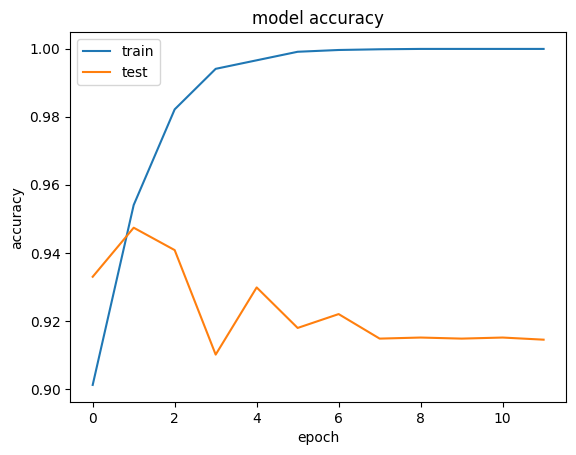

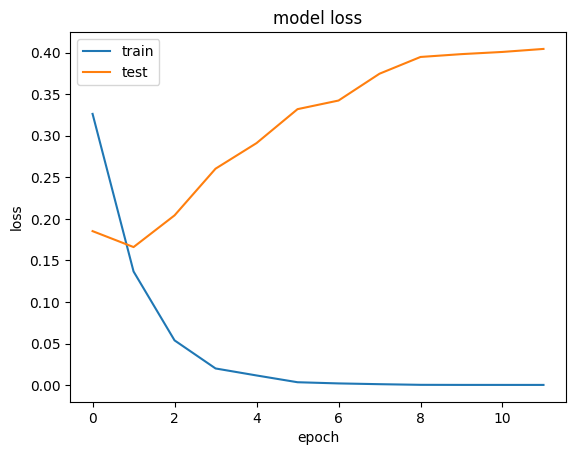

In [27]:
summarize_model(model, history, train_padded, train_labels, test_padded, test_labels)

In [34]:
def accuracy_report(testX, testy):
  # predict crisp classes for test set
  yhat_classes = model.predict(testX, verbose=0)
  classes_y = np.argmax(yhat_classes,axis=1)
  from sklearn.metrics import accuracy_score
  target_names =  ['class 0', 'class 1']
  print("Accuracy:", accuracy_score(testy, classes_y))

In [35]:
accuracy_report(test_padded, test_labels)

Accuracy: 0.9040774900208438


In [36]:
model.save('model.h5')